# Part 1 - Fetching all USA airports information

This section handles the extraction, parsing and cleaning of data related to all the airports and their flight connections within the United States of America.

In [48]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import time
import sys
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from typing import Dict, List
from tqdm import tqdm_notebook
from fake_useragent import UserAgent

In [49]:
url_main = "https://www.flightconnections.com/"
url_codes = "airport-codes"

In [50]:
def get_soup(url):
    res = requests.get(url, headers={'User-Agent': UserAgent().chrome})
    html = res.content
    soup = BeautifulSoup(html, 'lxml')
    return soup

In [51]:
soup = get_soup(url_main + url_codes)

There are numerous airports in USA which handles the incoming and outgoing traffic of the flights from different airlines through out the year. Each airport has a unique airport code which is extracted from the website ( link: https://www.flightconnections.com/airport-codes ). This data is extracted and parsed using Beautiful soup python library. The airport codes are present as a list in the “ul” HTML tag which has the class attribute as “airport-list”.

In [59]:
airport_list = soup.findAll("ul", attrs={"class":"airport-list"})
airport_list = [airport_group.findAll("li") for airport_group in airport_list]
airport_list = sum(airport_list, [])

This step is implemented on our modified Data Frame by creating a function that takes in two arguments i.e.. Destination (airport_codes) and source (airport_codes). In this function the data parsing is applied to extract the information such as the destination flights per month. This data is then converted to an integer for storing the int value of the count of destination flights.

In [60]:
def get_airport_info(airport)->Dict[str,str]:
    link = airport.find("a").get("href")
    link = link.replace("-to-", "-from-")
    code = airport.find("span", attrs={"class":"airport-code"}).text
    name = airport.find("span", attrs={"class":"airport-name"}).text
    city_country = airport.find("span", attrs={"class":"airport-city-country"}).text
    cc = city_country.split(", ")
    city = cc[0]
    country = cc[1]
    return {"link":link, "code":code, "name":name, "city":city, "country":country}

'''
<li>
 <a href="/flights-to-anaa-aaa" title="Direct flights to Anaa (AAA)">
 <div class="country-airports-info">
 <p class="airport-city"><span class="airport-code">AAA</span><span class="airport-city-country">Anaa, French Polynesia</span></p>
 <p><span class="airport-name">Anaa Airport</span></p>
 </div>
 </a>
 </li>

O/P:

{"link":"flights-from-anaa-aaa", "code":AAA, "name":"Anaa Airport", "city":"Anaa", "country":"French Polynesia"}
'''

'\n<li>\n <a href="/flights-to-anaa-aaa" title="Direct flights to Anaa (AAA)">\n <div class="country-airports-info">\n <p class="airport-city"><span class="airport-code">AAA</span><span class="airport-city-country">Anaa, French Polynesia</span></p>\n <p><span class="airport-name">Anaa Airport</span></p>\n </div>\n </a>\n </li>\n\nO/P:\n\n{"link":"flights-from-anaa-aaa", "code":AAA, "name":"Anaa Airport", "city":"Anaa", "country":"French Polynesia"}\n'

This data now contains all the columns/fields that are related to our analysis, but since we are analyzing the spread of the disease within the United states of America we had to implement a filter on the column that provides the information about the country wise airport codes. After inspecting the website, we observed that there is class attribute that provides with our desired information and thus we implemented a find function which searches for the class attribute and extracts the city and country of the airport code in a text format. A split function is applied on the extracted data to modify it into a more organized tabular format.

In [62]:
airport_info = []

for airport in tqdm_notebook(airport_list):
    airport = get_airport_info(airport)
    if airport["country"] == "United States":
        airport_info.append(airport)

<ipython-input-62-c2e010333845>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for airport in tqdm_notebook(airport_list):


In [8]:
result = pd.DataFrame(airport_info)
result.to_csv("../data/airport_info.csv")

In [9]:
airport_info = pd.read_csv("../data/airport_info.csv", index_col=0)
airport_info.head()

,link,code,name,city,country
0,/flights-from-allentown-abe,ABE,Lehigh Valley International Airpo,Allentown,United States
1,/flights-from-abilene-abi,ABI,Abilene Regional Airport,Abilene,United States
2,/flights-from-ambler-abl,ABL,Ambler Airport (FAA: AFM),Ambler,United States
3,/flights-from-albuquerque-abq,ABQ,Albuquerque International Sunport,Albuquerque,United States
4,/flights-from-aberdeen-abr,ABR,Aberdeen Regional Airport,Aberdeen,United States


## Visiting every airport link in USA and finding connections in USA

In [10]:
def get_airport_info(destination, source_airport)->Dict[str,str]:
    name = destination.find("div", attrs={"class":"popular-destination-airport-name"}).text
    destination_code = re.findall("\((.*?)\)", name)[0]
    country = destination.find("img").get("title")
    
    destination_flights_per_month = destination.find("span", attrs={'class':"float-right"}).text.strip()
    destination_flights_per_month = re.findall('\d+', destination_flights_per_month)[0]
    if destination_flights_per_month.isdigit():
        destination_flights_per_month = int(destination_flights_per_month)
    
    return {"source_code":source_airport, "destination_code": destination_code, "flights_per_month": destination_flights_per_month, "country":country}

This function is used to extract the data related to the destination airport_codes of the flights that were originating from our concerned airports. As per the observation there are numerous destinations for a flight originating from a source including the international airports. Hence in this function we are extracting the city-country and other details of the destination airport and implementing a filter of “United States”. This filter is applied so that we can extract only those paths (source – destination) which are being used within Unites States of America. This destination airport code information is then appended into the pre-existing data frame.
It is then iterated over every airport to find the list of destination airport_codes against each of them. This information is then grouped and appended in the data frame which now consists the vital information on routes such as the Source airport and its numerous destination airports. This is now extracted into .csv file and stored in the data folder as routes.csv.

In [11]:
def get_destinations_info(url_airport, source_airport)->List[Dict]:
#     print(url_main)
#     print(url_airport)
    flights_info = get_soup(url_main + url_airport)
    
    popular_destinations = flights_info.findAll("a", attrs={"class":"popular-destination btn"})
    popular_destinations_hidden = flights_info.findAll("a", attrs={"class":"popular-destination btn hide"})
    popular_destinations = popular_destinations_hidden + popular_destinations
#     print(popular_destinations)
    
    destinations_info = []

    for destination in tqdm_notebook(popular_destinations):
        destination = get_airport_info(destination, source_airport)
        if destination["country"] == "United States":
            destinations_info.append(destination)
    return destinations_info

In [12]:
full_destination_routes = []

exceptions = []

for row in tqdm_notebook(airport_info.itertuples(), total=airport_info.shape[0]):
    url_airport = row.link
    print(url_airport)
    source_airport = row.code
#     print(source_airport)
    try:
        destinations = get_destinations_info(url_airport, source_airport)
        full_destination_routes.extend(destinations)
    except Exception as e:
        if e == KeyboardInterrupt:
            break            
        else:
            print(e, url_airport, source_code)
        exceptions.append([e, url_airport, source_code])
    time.sleep(0.5)


/flights-from-destin-fort-walton-beach-vps



/flights-from-vieques-vqs



/flights-from-vero-beach-vrb



/flights-from-wales-waa



/flights-from-stebbins-wbb



/flights-from-selawik-wlk



/flights-from-meyers-chuck-wmk



/flights-from-white-mountain-wmo



/flights-from-napakiak-wna



/flights-from-wrangell-wrg



/flights-from-noatak-wtk



/flights-from-tuntutuliak-wtl



/flights-from-north-whale-pass-wwp



/flights-from-newtok-wwt



/flights-from-west-yellowstone-wys



/flights-from-fayetteville-xna



/flights-from-williston-xwa



/flights-from-yakutat-yak



/flights-from-yakima-ykm



/flights-from-yuma-yum


In [13]:
full_destination_routes = pd.DataFrame(full_destination_routes)
full_destination_routes.to_csv("../data/routes.csv")

In [14]:
full_destination_routes.shape

(6802, 4)

In [15]:
full_destination_routes

,source_code,destination_code,flights_per_month,country
0,ABE,DTW,88,United States
1,ABE,CLT,79,United States
2,ABE,ORD,56,United States
3,ABE,ATL,42,United States
4,ABE,SFB,31,United States
...,...,...,...,...
6797,YAK,JNU,30,United States
6798,YAK,CDV,30,United States
6799,YKM,SEA,62,United States
6800,YUM,PHX,98,United States


# Part 2 - Fetching Airport Data Dump from https://openflights.org/data.html

Till now we had done an excellent job to find out the information that provided us the information on all the possible airway routes within the USA. But sadly, this was not enough for us to analyze the rate of spread of disease as we did not have enough details about these routes.
In order to fetch a detailed information about various air travel through the various airports we extracted and parsed a data dump from a website (link: https://openflights.org/data.html ). This website has a airport.dat file which consists of an extensive detailed information about every airport such as the latitude, longitude, city, country, time-zone etc.
In order to extract the useful information from this data dump we considered only the important columns related to our application and dropped the unnecessary ones. It is then stored in a .csv file which is then further used to perform some pre-processing in order to filter out the information of the airports which are in United States only. This data frame is now a vital data set which helps us in determining the various informative details that can used to analyze the spread of a disease through air travel. This data set is stored in a .csv file in the data folder.

In [86]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_data = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                        names = airport_col, index_col = 0)
airport_data = airport_data.drop(['ICAO','source', 'type','Tz database time zone','DST','Timezone','Alt'], axis=1)
airport_data.to_csv("../data/airport_data_openflights.csv")


In [87]:
#Pre-processing the airport data to filter for United States only and removing unecessary columns.

filePath = "../data/airport_data_openflights.csv"
with open(filePath)	as csvfile:
    reader = csv.DictReader(csvfile)

    filePath = "../data/temp.csv"
    with open(filePath,'w',newline='') as csvfile:
#         fieldnames = ['ID','Name','City','Country','IATA','ICAO','Lat','Long','Alt','Timezone','DST','Tz database time zone','type','source']
        fieldnames = ['ID','Name','City','Country','IATA','Lat','Long']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        for row in reader:
            if row['Country'] == "United States":
                writer.writerow(row)

header_list = ['ID','Name','City','Country','IATA','Lat','Long']
airport_data = pd.read_csv("../data/temp.csv", names=header_list)
# airport_data = pd.read_csv("../data/temp.csv")
airport_data = airport_data[~airport_data.IATA.isin([r"\N"])]
airport_data.to_csv('../data/airport_data_openflights_cleaned.csv', index=False)

In [88]:
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001
2,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001
3,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005
4,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004
5,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901


# Part3 - Fetching Airport Connections Data Dump From https://openflights.org/data.html

The data that we had acquired till now was still incomplete as few more details about a flight trip such as the stops, airline etc. was still missing. In order to achieve those data, we extracted this relevant data dump from the website (link: https://openflights.org/data.html ) which consisted of file name routes.dat. This data is then processed and stored on a connections_world.csv file in the data folder.

In [120]:
connections_cols = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
connections_world = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = connections_cols)
connections_world.to_csv("../data/connections_world.csv")

In [121]:
connections_world.shape

(67663, 9)

## Plotting Python Scatter Plot of US Airports across latitude vs longitude

In order to visualize the spread of airports across the US we plotted the latitude and longitude of the airports from the data that we had extracted into one of our data frames.
In order to plot this, we have used the matplotlib library and have provide the colors of the land and sea along with the borders.

/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


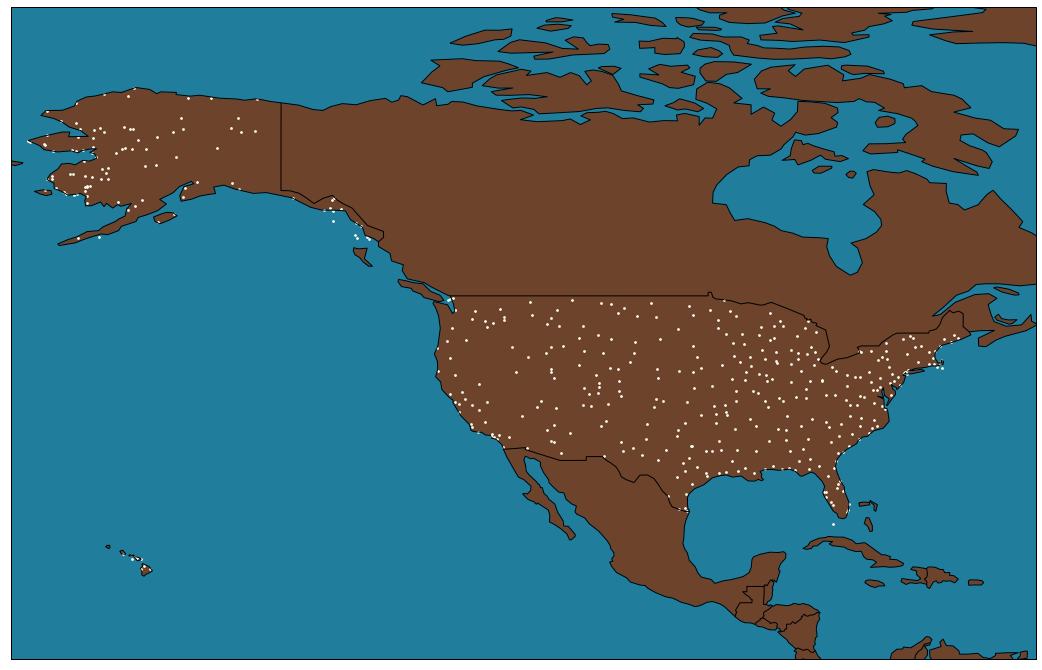

In [123]:
# full_destination_routes -> From routes.csv
# connections_world -> connections_world.csv
# airport_data -> airport_data_openflights_cleaned.csv

plt.figure(figsize=(25, 12))
plt.title("USA airports")
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
# ax.outline_patch.set_visible(False)
ax.add_feature(cfeature.LAND, color='#6D432B')
ax.add_feature(cfeature.OCEAN, color='#207D9C')
plt.scatter(airport_data.Long, airport_data.Lat, s=3, c='#F9FAEC')
plt.xlim(-170, -60)	
plt.ylim(10, 80)
sns.despine()
plt.show()

## Left join US airports destination routes with all connections in world data

Now in order to create a complete informative data frame we took the airport routes data set that we had stored earlier and performed a left- join on the flight connections data dump that we recently created. Due to this operation, we have now achieved a data set which contains a detailed information about all the possible travel transactions that can be performed from an airport.

In [92]:
connections = pd.merge(
    full_destination_routes,
    connections_world,
    how='left', 
    left_on=['source_code', 'destination_code'], 
    right_on=['Source Airport', 'Dest Airport']
)

connections.drop(
    ['source_code', 'destination_code', 'Codeshare', 'Stops', 'equipment'],
    axis=1, inplace=True
)

connections.columns = connections.columns.str.lower().str.split().str.join("_")
connections.head()

,flights_per_month,country,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id
0,88,United States,DL,2009,ABE,4355,DTW,3645
1,79,United States,AA,24,ABE,4355,CLT,3876
2,79,United States,US,5265,ABE,4355,CLT,3876
3,56,United States,UA,5209,ABE,4355,ORD,3830
4,42,United States,AF,137,ABE,4355,ATL,3682


This is a complete informative data set that we achieved after it was joined, processed and extracted from various data sources, but it still needs some data cleaning operation to be performed on it. So the first step to this is to analyze the amount of null values in our data set.

In [93]:
# Checking if any valuable data is missing
connections.isnull().sum()/connections.shape[0]*100

flights_per_month     0.000000
country               0.000000
airline              17.478977
airline_id           17.478977
source_airport       17.478977
source_airport_id    17.478977
dest_airport         17.478977
dest_airport_id      17.478977
dtype: float64

## Adding US Airports Longitude and Latitude data to connections table above

In [94]:
connections = pd.merge(
    connections, airport_data[['IATA', 'Lat', 'Long']], left_on='source_airport', right_on='IATA')

connections = pd.merge(
    connections, airport_data[['IATA', 'Lat', 'Long']], left_on='dest_airport', right_on='IATA')

connections.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)
connections.rename(columns={
    'Lat_x':'latitude_source', 
    'Long_x':'longitude_source',
    'Lat_y':'latitude_dest',
    'Long_y':'longitude_dest'
}, inplace=True)
connections.head()
connections.to_csv("../data/temp_connections.csv")

## Adding top 200 fetched US cities population to airport_data

In [95]:
# Run US_Cities_Population.ipynb first to get the us_top_200_city_population.csv file generated

population_city = pd.read_csv("../data/us_top_200_city_population.csv", index_col=0)
print(population_city.shape)
population_city.head()

(200, 8)


,Rank,Name,State,2020 Pop,2010 Census,Change,Density (km²),Area (km²)
0,1,New York City,New York,8323340,8190360,1.62%,10699,778
1,2,Los Angeles,California,4015940,3795370,5.81%,3306,1215
2,3,Chicago,Illinois,2694240,2697530,-0.12%,4575,589
3,4,Houston,Texas,2340890,2098450,11.55%,1412,1658
4,5,Phoenix,Arizona,1703080,1449300,17.51%,1270,1341


## Fetching Population Data from a more bigger dataset from opendatasoft.com

While moving ahead with the simulation part for this project we realized that in order to create a simulation of the spread of disease we need to include the information about the latitude and longitude of the airports so that a link can be generated between the airports that perform air travel between each other. Hence we added US Airports Longitude and Latitude data to the connections table above by performing a left outer join of the latitude data on the connections table data.
So now after performing these operations we had created a base data that can perform an analysis on the spread of any disease in the United States.
But in order to determine the rate of transfer of this disease we added one more important factor that impacts the rate of transmission i.e., population of the region/country. In order to get this information on the population we had performed a data processing in the first section that provided us the with USA’s city wise population which is stored in the .csv file in the data folder.
This information that we have pulled out was for top 200 USA cities This file provides the information about the population city-wise along with few other factors such as total area of the region, population density etc.

In [96]:
resp = requests.get('https://public.opendatasoft.com/api/records/1.0/search/?dataset=geonames-all-cities-with-a-population-1000&q=&rows=10000&sort=population&facet=timezone&facet=country&refine.country=United+States')
outDict = json.loads(resp.text)

cityPop = []

for record in outDict["records"]:
    name = record["fields"]["name"]
    population = record["fields"]["population"]
    cityPop.append({"name":name, "population":population})

cityPop = pd.DataFrame(cityPop)
cityPop.to_csv("../data/us_all_cities_population.csv")

In [97]:
cityPop.head()

,name,population
0,New York City,8175133
1,Los Angeles,3971883
2,Chicago,2720546
3,Brooklyn,2300664
4,Houston,2296224


In [98]:
airport_data = pd.read_csv("../data/airport_data_openflights_cleaned.csv")
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901


As we had the flight and airport information about almost all the cities in USA we fetched the population data from a bigger dataset from opendatasoft.com only for USA. After this operation we performed a left outer join on airport connections data and merged it with the population data.

In [99]:
airport_merged_data = pd.merge(
    airport_data, 
    cityPop.rename(
        columns={"name":"City"}
    ).drop_duplicates(subset=['City']), 
    how='left',
    on='City'
)
airport_merged_data.to_csv("../data/us_airport_population_merged.csv")
airport_merged_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901,270934.0


As this was a left join operation it was bound that there will be some null values in the population column that was merged with the connections data set. In order to get a brief idea on the null values present in various columns of the data set we pulled out brief statics about it as mentioned below:

In [100]:
airport_merged_data.isnull().sum()/airport_merged_data.shape[0]*100

ID             0.000000
Name           0.000000
City           0.000000
Country        0.000000
IATA           0.000000
Lat            0.000000
Long           0.000000
population    25.259792
dtype: float64

### For 25% cities population is missing, so Hypothesis - the number of flights from the city is proportional to the city population

As it is clearly evident that 25% of the population data is missing we came with a solution in which we will provide an estimated value of the population in the null areas by performing a Hypothesis. The Hypothesis is that the number of flights from the city is proportional to the city population. Based on this calculation an estimate value can be predicted for the cities for which there is no data present in the data set.
In order to implement and perform this hypothesis a few data processing steps are required. The first step to this aggregating the flight_per_month column according to the source_airport code. These flights per month values are then merged with the connections data set. The merging process is a left join of the collections data on the data set containing values for flights_per_month.

In [101]:
flights_number = connections.groupby(
    ['source_airport'], as_index=False
)[['flights_per_month']].sum()
flights_number.head()

,source_airport,flights_per_month
0,ABE,485
1,ABI,266
2,ABL,100
3,ABQ,2329
4,ABR,62


In [102]:
# adding source airport number of flights to the airport dataframe
airport_merged_data_with_flightsCount = pd.merge(
    airport_merged_data, flights_number, 
    how='left', 
    left_on='IATA', 
    right_on='source_airport'
)
airport_merged_data_with_flightsCount.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN,BTI,27.0
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN,LUR,4.0
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN,PIZ,27.0
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0
4,3416,Orlando Executive Airport,Orlando,United States,ORL,28.545500,-81.332901,270934.0,NaN,NaN


In [103]:
airport_data = airport_merged_data_with_flightsCount[~airport_merged_data_with_flightsCount.source_airport.isnull()]
airport_data = airport_data[~airport_data.flights_per_month.isnull()]
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN,BTI,27.0
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN,LUR,4.0
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN,PIZ,27.0
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0
5,3417,Bettles Airport,Bettles,United States,BTT,66.913902,-151.529007,NaN,BTT,31.0


In [104]:
airport_data.isnull().sum()/airport_data.shape[0]*100

ID                    0.000000
Name                  0.000000
City                  0.000000
Country               0.000000
IATA                  0.000000
Lat                   0.000000
Long                  0.000000
population           27.548807
source_airport        0.000000
flights_per_month     0.000000
dtype: float64

### Find USA Population from https://worldpopulationreview.com/countries/united-states-population

In our next step we are finding out the flight coefficient. This flight coefficient according to our Hypothesis is derived through a mathematical division operation in which the Total Population of US is divided by the flights per month that is operating in US.
In order to get the total flights_per_month we just aggregated the entire flights count upto the country level. The total population of the country is a dynamic and live updated value which is fetched from the website (link: https://worldpopulationreview.com/countries/united-states-population ). Thus due to this the flight coef. is derived as per below:

In [105]:
population_link = "https://worldpopulationreview.com/countries/united-states-population"
soup = get_soup(population_link)

In [106]:
usa_population = soup.find("span", attrs={"style":"font-size: 36px;"}).text
usa_population = int(usa_population.replace(',',''))
usa_population

331848096

In [107]:
# average population per flight
flights_coefs = airport_data[
    ~airport_data.population.isnull()
].groupby("Country")[['flights_per_month']].sum()
flights_coefs['total_population'] = usa_population
flights_coefs['coef'] = usa_population/flights_coefs['flights_per_month']

In [108]:
flights_coefs

,flights_per_month,total_population,coef
Country,,,
United States,982351.0,331848096,337.810107


### Using this coefficient to fill the missing population data

Thus, this coef. Is now used to fill in the missing data in the population section by the calculation of:
City estimated Population: flight_coefficient * flights_per_month

The values that will be filled in the empty slots of the population column is an estimate value, but it is still enough for our application to perform operations and simulations.

In [109]:
airport_data['flights_coefficient'] = airport_data.Country.map(flights_coefs.coef)
airport_data['flights_coefficient'].fillna(airport_data['flights_coefficient'].median(), inplace=True)
airport_data

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month,flights_coefficient
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,NaN,BTI,27.0,337.810107
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,NaN,LUR,4.0,337.810107
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,NaN,PIZ,27.0,337.810107
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0,337.810107
5,3417,Bettles Airport,Bettles,United States,BTT,66.913902,-151.529007,NaN,BTT,31.0,337.810107
...,...,...,...,...,...,...,...,...,...,...,...
970,8200,Toksook Bay Airport,Toksook Bay,United States,OOK,60.541401,-165.087006,NaN,OOK,0.0,337.810107
994,8314,Hilton Head Airport,Hilton Head Island,United States,HHH,32.224400,-80.697502,40512.0,HHH,198.0,337.810107
1112,9543,Ogden Hinckley Airport,Ogden,United States,OGD,41.195900,-112.012001,85444.0,OGD,7.0,337.810107
1115,9739,Napakiak Airport,Napakiak,United States,WNA,60.690300,-161.979004,NaN,WNA,54.0,337.810107


In [110]:
city_estimates = np.ceil(airport_data.flights_coefficient[airport_data.population.isnull()] *\
                 airport_data.flights_per_month[airport_data.population.isnull()])

airport_data.population[airport_data.population.isnull()] = city_estimates

<ipython-input-110-e5d88e543a9d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airport_data.population[airport_data.population.isnull()] = city_estimates


In [111]:
airport_data.isnull().sum()/airport_data.shape[0]*100

ID                     0.0
Name                   0.0
City                   0.0
Country                0.0
IATA                   0.0
Lat                    0.0
Long                   0.0
population             0.0
source_airport         0.0
flights_per_month      0.0
flights_coefficient    0.0
dtype: float64

### Cleaning connections data

In [112]:
connections = connections[connections.source_airport.isin(airport_data.IATA)]
connections = connections[connections.dest_airport.isin(airport_data.IATA)]

These entire series of steps starting from data parsing through various websites, data extraction and data processing through various functions has provided us with the desired data set which are now divided and stored in two separate .csv files:

In [114]:
airport_data.to_csv("../data/airport_data_preprocessed.csv")
connections.to_csv("../data/connections_preprocessed.csv")

In [115]:
connections.head()

,flights_per_month,country,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,latitude_source,longitude_source,latitude_dest,longitude_dest
0,88,United States,DL,2009,ABE,4355,DTW,3645,40.652100,-75.440804,42.212399,-83.353401
1,90,United States,DL,2009,ALB,3864,DTW,3645,42.748299,-73.801697,42.212399,-83.353401
2,53,United States,DL,2009,APN,5720,DTW,3645,45.078098,-83.560303,42.212399,-83.353401
3,337,United States,AF,137,ATL,3682,DTW,3645,33.636700,-84.428101,42.212399,-83.353401
4,337,United States,AM,321,ATL,3682,DTW,3645,33.636700,-84.428101,42.212399,-83.353401


In [116]:
airport_data.head()

,ID,Name,City,Country,IATA,Lat,Long,population,source_airport,flights_per_month,flights_coefficient
0,3411,Barter Island LRRS Airport,Barter Island,United States,BTI,70.134003,-143.582001,9121.0,BTI,27.0,337.810107
1,3413,Cape Lisburne LRRS Airport,Cape Lisburne,United States,LUR,68.875099,-166.110001,1352.0,LUR,4.0,337.810107
2,3414,Point Lay LRRS Airport,Point Lay,United States,PIZ,69.732903,-163.005005,9121.0,PIZ,27.0,337.810107
3,3415,Hilo International Airport,Hilo,United States,ITO,19.721399,-155.048004,43263.0,ITO,634.0,337.810107
5,3417,Bettles Airport,Bettles,United States,BTT,66.913902,-151.529007,10473.0,BTT,31.0,337.810107
